# Introduction

Have you ever read a doctor's note and wondered how could anyone read this? Funny thing is, other doctors and pharmacists are able to decipher that. So I wonder, what if its possible to have a machine to recognize handwriting. Not doctor's handwriting, definitely not that. I don't even think a machine can read it either. We got to start somewhere somehow. In this report we will go over some algorithms to try to recognize some characters. We will only go over a set of 5 characters, rather than 10 given. 

# Data
The data we will be using is from the class Data-Oriented Computing for Mathematics taught by Dr. John Ringland. The students of the class submitted personal handwriting samples of characters and Dr. Ringland compiled the list of data for us to use. We are also using data from Sasha Trubetskoy, an arbitrary set of simple, distinct colors.

# Getting Started

For this report we will be using the following tools and packages: image from PIL, glob, numpy, matplotlib.pyplot, matplotlib.image, rcparams from matplotlib, pandas, and spatial and KDTree from scipy. 

In [1]:
from PIL import Image
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import pandas as pd
%matplotlib inline
import numpy as np
from scipy import spatial
from scipy.spatial import KDTree

Here are the functions we will be using in the report. The function charclass will strip the name of the png file name, and give us the character that png is. This will be useful in our set comprehension and our solution set result. The scatter function is responsible of taking in a set of png files (training set, then the test set) and giving us their distinct characteristics. We will see their distinctiveness through the matplot, we will (hopefully) see that each character separated into different regions on the plot. Of course we will be creating these "features" that distinguish each character. Lastly, near the bottom of the report, we have a function called showimage which will basically put two plots next to each other so we can closely examine their differences.

In [2]:
def charclass(png):
    return png.split('__')[1][:-4]

So the features I included apart from the given, were 'up concavity','zero angle, and 'max angle'. Essentially, up concavity is the same as right concavity except that it will check for concavity on top. I've done this for the purpose of distinguishing the character 'V' from the others. 'Zero angle' and 'Max angle' refers to the slope of the character, whether they are a straight line in the vertical direction or the horizontal direction. How I did this was, I will sum up each coloumn or row, and then find its argmax to get the largest sum. This sum will tell us if the character is long in the vertical or horizontal direction. I also included a few global arrays to store some temporary data within the function.

In [3]:
array = []
tempcolor = []
cmap0 = []
def scatter(pngs):
    for png in pngs:
        img = Image.open(png)
        break

    a = np.array(img)
    a = a[:,:,0]
    a = 255 - a
    h,w = a.shape

    n = len(pngs)
    #features = ['ink','log aspect','lr-asymmetry','right concavity','vertical reflection']
    #features = ['ink','right concavity','up concavity','zero angle','max angle']
    features = ['ink','max angle']
    d = len(features)
    F = np.empty((d,n))
    x = np.arange(0,w) # linspace(0,w,w,endpoint=False)
    y = np.arange(0,h) # linspace(0,h,h,endpoint=False)
    X,Y = np.meshgrid(x,y)

    for k,png in enumerate( pngs ):
            #print(png)
            img = Image.open(png)
            #imshow(img)
            a = np.array(img)
            a = a[:,:,0]  # get just one layer- they are all the same
            a = 255 - a   # invert so character is high values
            ink  = a.sum() / (h*w*255)   # scaled to [0,1]  # maybe too extreme?  # better alternatives
            if ink == 0:
                print('Blank image:',png)
                assert ink>0
            F[0 ,k] = ink

            # height and width of character
            xmin = X[ a>0 ].min()
            xmax = X[ a>0 ].max()
            ymin = Y[ a>0 ].min()
            ymax = Y[ a>0 ].max()
            logaspect = np.log10((ymax-ymin)/(xmax-xmin))
            #F[1 ,k] = logaspect

            # left-right asymmetry
            cbbx = (xmin+xmax)/2   # center of bounding box
            cogx = (X*a).sum() / a.sum() # x-coordinate of center of mass of ink
            lrasymmetry = (cogx-cbbx) / (xmax-xmin)
            #F[2 ,k] = lrasymmetry

            # right concavity
            #xstar = w - np.argmax( np.fliplr(a) > 0, axis=1 ).max()
            #F[1, k] = (xmax-xstar)/(xmax-xmin)

            #up concavity
            #ystar = h - np.argmax( np.flipud(a) > 0,axis = 1).max()
            #F[2,k] = (ymax-ystar)/(ymax -ymin)

            #zero angle     
            #F[3,k] = np.argmax(np.sum(a,axis=1))   

            #max angle
            F[1,k] = np.argmax(np.sum(a,axis=0))

    colors21  = ['#e6194b', '#3cb44b', '#ffe119', 
                 '#4363d8', '#f58231', '#911eb4', 
                 '#46f0f0', '#f032e6', '#bcf60c', 
                 '#fabebe', '#008080', '#e6beff', 
                 '#9a6324', '#fffac8', '#800000', 
                 '#aaffc3', '#808000', '#ffd8b1', 
                 '#000075', '#808080', '#000000']
    global array
    global tempcolor
    global cmap0
    array = F
    charclasses = sorted({charclass(png) for png in pngs})   # set comprehension
    cmap = {cc:color for cc,color in zip(charclasses,colors21)}
    colors = [cmap[charclass(png)] for png in pngs]
    plt.figure(figsize=(10,10))
    cmap0 = cmap
    for i in range(d):
            for j in range(d):
                plt.subplot(d,d,i*d+j+1)
                if i==j:
                    plt.text(.5,.5,features[i],ha='center')
                    plt.xticks([])
                    plt.yticks([])
                else:
                    tempcolor = colors
                    plt.scatter( F[j,:], F[i,:] , s=2, c=colors, alpha=0.7 )
                    plt.legend(cmap)

Now we will pull in our "training data", which is our data where we "teach" the algorithm what should be what. We pull in the pngs folder containing around 1500 samples. We will be using the character set of 'C','0','period','minus', and '1'.
After playing around a bit, I found that the features, 'ink' and 'max angle', provide the best results for distinguishing the characters. The follow we could see that with these 5 characters, we were able to get 7 very distinct regions, but worry not. The extra region you see for blue and red still counts as distinct. Each color represents a different character.

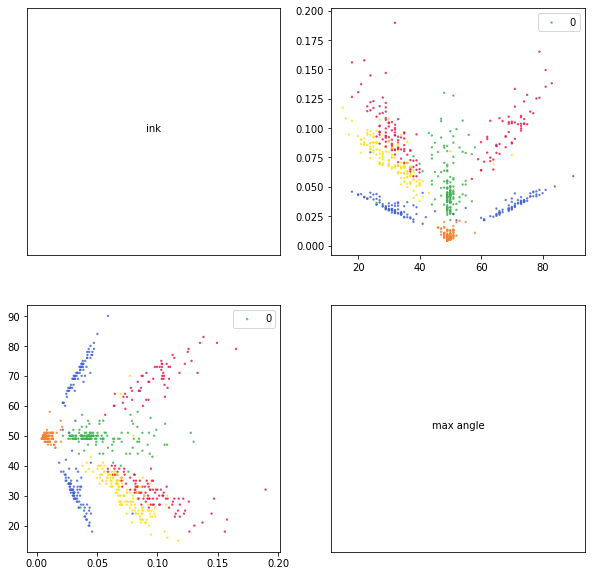

In [4]:
pngs = sorted(glob.glob('pngs/*.png'))#[:5]  # new cleaned pngs folder after class
#pngs = [png for png in pngs if charclass(png)]
pngs = [png for png in pngs if charclass(png) in ['C','0','period','minus','1']] #the set we are testing

scatter(pngs)

We will now take the data from the global array and store them in a more 'permanent' array. Here we are storing all the coordinates for each sample png. We then transpose that array and put it into a dataframe. I like using dataframe don't judge. I will also take all its respective color and store it into the dataframe. Now we run into the issue that color is we don't know what color is what character. I've also included its testing png file.

In [5]:
basecolor = tempcolor
background = np.transpose(array)
sorry = pd.DataFrame(background,columns=['x','y'])
sorry['color'] = basecolor
sorry['img'] = pngs

Thankfully we have a dictionary that tells us what color is what character. However the dictionary is inverted, ie. '1' is red. What we want is Red is '1'. So we will invert the dictionary and replace its prior column. We now store the x and y axis into the KDtree for later.

In [6]:
cmap1= dict((v,k) for k, v in cmap0.items()) #flipping the dictionary
sorry.replace({'color': cmap1},inplace=True)
tree = KDTree(sorry[['x','y']])

Now we will pull in the testing set of data. We call the scatter function to plot these data points. Like before we will use 5 characters. 

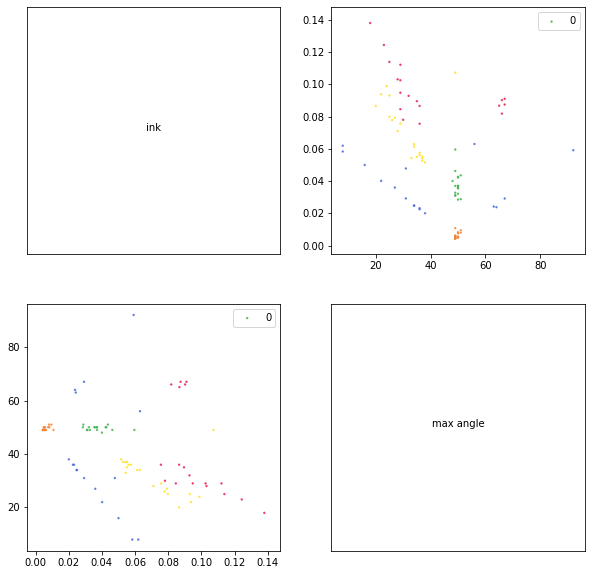

In [7]:
testpngs = sorted(glob.glob('testpngs/*.png'))#[:50]  # new cleaned pngs folder after class
#testpngs = [png for png in testpngs if charclass(png)]
testpngs = [png for png in testpngs if charclass(png) in ['C','0','period','minus','1']] #the set we are testing
scatter(testpngs)

We can see even more clearly than the previous training set plot. This plot has (of course less samples) very distinct regions. Proving that our feature works well even with this set of data. However, we can see that some of the yellow and red are really close to one another. Also to mention those two blue points are close to a yellow and a green.
Like before we will transpose the array, and store it into scallion. Then we put that data into the query tree to find each point's nearest neighbor.

In [8]:
scallion = np.transpose(array)
dist, idx = tree.query(scallion,1)
#idx

We now received the index of the nearest neighbor of those points, now we can plug each idx value into the dataframe table in the 'color' column. We will store the results into the answer array and then we will create a dictionary of all its unique characters and how many times it was found or recognized.

In [9]:
answer = []
resultpngs = []
for item in idx:
    answer.append(sorry['color'].iloc[item])
    resultpngs.append(sorry['img'].iloc[item])
uniqueVal, occurrence = np.unique(answer, return_counts=True)
results = dict(zip(uniqueVal,occurrence))

We will also do the same for the actual solution, by using the charclass function to get the character name of each png image, and store them into the answerkey array. Then we will create another dictionary of unique characters and its occurrence.

In [10]:
answerkey=[]
for i in range(len(testpngs)):
    answerkey.append(charclass(testpngs[i]))
solVal, solOcc = np.unique(answerkey, return_counts=True)
answerkey = dict(zip(solVal,solOcc))

Finally we will show you the result of this algorithm. We will count how many times there is a match and how many times its a miss. Then we calculate its accuracy. We will also display the dictionary of results and answerkey.

In [11]:
sorry

,x,y,color,img
0,0.045323,49.0,1,pngs\000_20191024_ringland__1.png
1,0.077237,44.0,1,pngs\000_20191030_amishra6__1.png
2,0.079885,54.0,1,pngs\000_20191030_badzioch__1.png
3,0.041119,50.0,1,pngs\000_20191030_betsymcc__1.png
4,0.041826,49.0,1,pngs\000_20191030_cahamp__1.png
...,...,...,...,...
753,0.006047,50.0,period,pngs\098_20191030_usmanhus__period.png
754,0.007339,50.0,period,pngs\099_20191024_ringland__period.png
755,0.016617,51.0,period,pngs\099_20191030_gifariho__period.png
756,0.013091,50.0,period,pngs\099_20191030_jacobalm__period.png


In [12]:
wrongset = []
correctset = []
true = 0
false = 0
for i in range(len(testpngs)):
    if answer[i] == charclass(testpngs[i]):
        true = true + 1
        correctset.append((resultpngs[i],testpngs[i]))
    else:
        false = false + 1
        wrongset.append((resultpngs[i],testpngs[i]))
        #print(sorry['img'][i])
        #print(testpngs[i])
        #print()
accuracy = (true/(len(testpngs))) * 100

print('Here is my assessment:')
print('------------------------------------------------------------------------------')
print("Here are the characters I recognize and the number of time I think I saw them:")
print(results)
print()
print("Here is the actual answer:")
print(answerkey)
print('------------------------------------------------------------------------------')
print('I received ' + str(len(testpngs)) + ' images.')        
print('I guessed '+ str(true) + ' correct.')        
print('I got '+ str(false) + ' wrong.')        
print('I am '+ str(accuracy) + '% accurate.')

Here is my assessment:
------------------------------------------------------------------------------
Here are the characters I recognize and the number of time I think I saw them:
{'0': 15, '1': 18, 'C': 24, 'minus': 15, 'period': 18}

Here is the actual answer:
{'0': 18, '1': 17, 'C': 20, 'minus': 17, 'period': 18}
------------------------------------------------------------------------------
I received 90 images.
I guessed 81 correct.
I got 9 wrong.
I am 90.0% accurate.


We see that with 5 out of the 10 sets, we were able to get 90% accuracy. There were 90 usable images from the test folder and only 9 was incorrect. We can also see where it went wrong in distinguishing characters. The period is the most accurate character to distinguish.

But let's actually find out what really went wrong. The following is a list of corresponding images, the img of the nearest neighbor (the closest resemblance to the test image) and the result of the test image.

In [13]:
wrongset

[('pngs\\048_20191030_darshkir__C.png',
  'testpngs\\022_20191108_dmitriki__0.png'),
 ('pngs\\048_20191030_jdkazime__C.png',
  'testpngs\\025_20191108_dmitriki__minus.png'),
 ('pngs\\020_20191030_jdkazime__1.png',
  'testpngs\\035_20191108_dmitriki__minus.png'),
 ('pngs\\028_20191030_zoeherri__C.png',
  'testpngs\\042_20191108_ringland2__0.png'),
 ('pngs\\028_20191030_jdkazime__C.png',
  'testpngs\\045_20191108_dmitriki__minus.png'),
 ('pngs\\087_20191030_darshkir__1.png',
  'testpngs\\048_20191108_dmitriki__C.png'),
 ('pngs\\045_20191030_usmanhus__minus.png',
  'testpngs\\060_20191108_dmitriki__1.png'),
 ('pngs\\028_20191030_jdkazime__C.png',
  'testpngs\\075_20191108_dmitriki__minus.png'),
 ('pngs\\065_20191030_darshkir__minus.png',
  'testpngs\\092_20191108_ringland2__0.png')]

Here we get all the filenames of the set we failed to identify correctly.

The following function is made for the very purpose of displaying the result image side to side for every wrong set of images.

In [14]:
def showimage(img1,img2):
    img_A = mpimg.imread(img1)
    img_B = mpimg.imread(img2)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(img_A);
    ax[1].imshow(img_B);

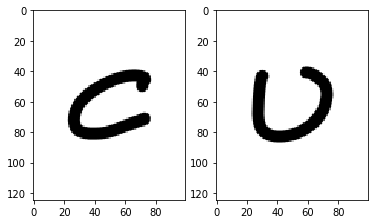

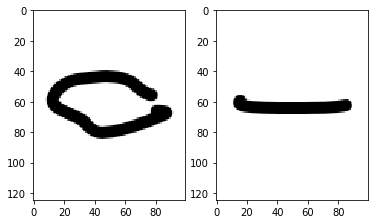

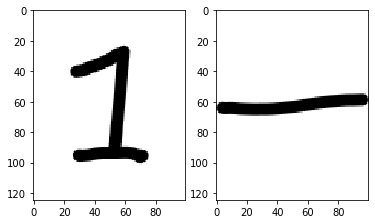

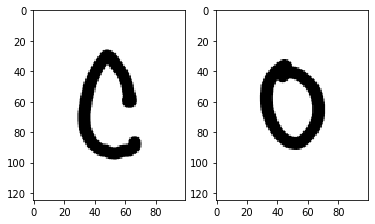

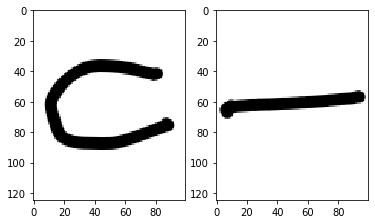

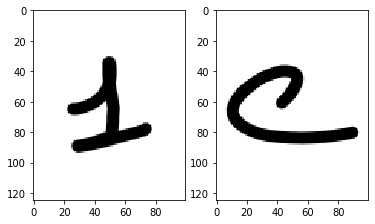

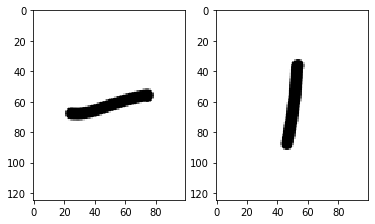

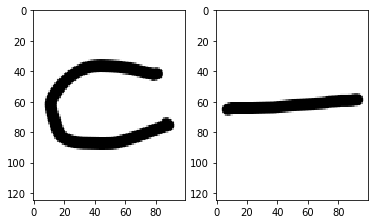

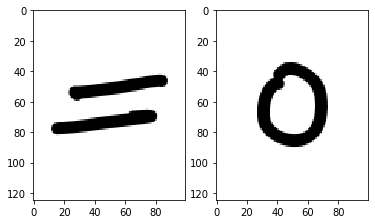

In [15]:
for i in range(len(wrongset)):
    showimage(wrongset[i][0],wrongset[i][1])
    #break

The above shows us the incorrect identification and for some of them I could understand why. Some of these characters have the same, or similar argmax of the vertical sum. Not only that the ink see to be similar as well. An example of this case would be the first set of characters (the 'C' and '0') you see above and some of the other cases, '1' and 'C'. Then there are couple of cases where I can understand when they have the same ink value, such as the '1' and 'minus' or sometimes 'C' and 'minus'. However, there was another feature to distinguish them by taking the argmax of the vertical sum. I cannot see why it failed to distinguish a 'minus' and a '1' when '1' has an obvious higher argmax value. Similarly a less deviation of argmax between 'C' and 'minus'. For the last set, I noticed a wrong classification on the set. It shows us a 'equals' image instead of what it was actually classified 'minus'.

Since we've taken a look at the wrong set of characters, let's dig into the correct set.

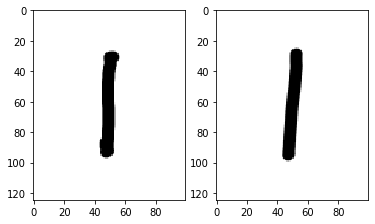

In [16]:
#correctset
for i in range(len(correctset)):
    showimage(correctset[i][0],correctset[i][1])
    break #I put a break here because I don't want to load 81 images in this cell.

Also I noticed something interesting that isn't shown in this report, but my time playing around. When I added more characters to the sets (6,7,8,9,10), I found that the accuracy drops increments of 5%, until 8. It then drops at 10 percent increments. Ultimately at 10 characters, it is 50% accurate. 

# Conclusion

From the report, we learned that by finding how tall or how wide the characters are can help determine what those characters actually are. In the report with 5 characters, we were able to get 90% accuracy of identifying what character is in the images are. We also taken a look into why and where did we go wrong. I realized in some of the cases for the incorrect set, there were issues I did not understand. Like how with consideration of maximum vertical sum, I am confused as in how the identifier failed to distinguish between a '1' and a 'minus'. We also saw the plot and their distinct regions, with occasion 1 or 2 outliers. 
But we realize as we add more characters to the set, our accuracy drops. Of course with more complex features, we will able to increase accuracy and increase the number of characters we can realize.
We then realize after digging into all the failed matches, we see that there are some true matches.
Maybe we will get to the level, of complex features, where we can identify what the doctors are actually saying. Maybe find out they were actually making fun of us, or telling us to pass love notes to the pharmacists. 